In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
! wget https://cedar.buffalo.edu/NIJ/data/signatures.rar


--2024-11-28 11:23:15--  https://cedar.buffalo.edu/NIJ/data/signatures.rar
Resolving cedar.buffalo.edu (cedar.buffalo.edu)... 128.205.32.52
Connecting to cedar.buffalo.edu (cedar.buffalo.edu)|128.205.32.52|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 253587033 (242M) [application/vnd.rar]
Saving to: ‘signatures.rar’

signatures.rar      100%[===================>] 241.84M  17.0MB/s    in 16s     

2024-11-28 11:23:32 (14.7 MB/s) - ‘signatures.rar’ saved [253587033/253587033]



In [3]:
!pip install unrar
!unrar x signatures.rar


UNRAR 6.11 beta 1 freeware      Copyright (c) 1993-2022 Alexander Roshal


Extracting from signatures.rar

Creating    signatures                                                OK
Creating    signatures/full_forg                                      OK
Extracting  signatures/full_forg/forgeries_10_1.png                        0%  OK 
Extracting  signatures/full_forg/forgeries_10_10.png                       0%  OK 
Extracting  signatures/full_forg/forgeries_10_11.png                       0%  OK 
Extracting  signatures/full_forg/forgeries_10_12.png                       0%  OK 
Extracting  signatures/full_forg/forgeries_10_13.png                       0%  OK 
Extracting  signatures/full_forg/forgeries_10_14.png                       0%  OK 
Extracting  signatures/full_forg/forgeries_10_15.png                       0%  OK 
Extracting  signatures/full_forg/forgeries_10_16.png                       0%  OK 
Extracting

In [ ]:
import os
import shutil
import random

# Define the ratios for splitting
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

def split_files(file_list):
    random.shuffle(file_list)
    total_files = len(file_list)

    train_end = int(total_files * train_ratio)
    val_end = train_end + int(total_files * val_ratio)

    train_files = file_list[:train_end]
    val_files = file_list[train_end:val_end]
    test_files = file_list[val_end:]

    return {
        'train': train_files,
        'val': val_files,
        'test': test_files
    }

def copy_files(file_list, src_dir, dest_dir):
    if not os.path.exists(dest_dir):
        os.makedirs(dest_dir)
    for file_name in file_list:
        shutil.copy(os.path.join(src_dir, file_name), os.path.join(dest_dir, file_name))

def main():
    genuine_dir = 'signatures/full_org'
    forged_dir = 'signatures/full_forg'

    genuine_files = os.listdir(genuine_dir)
    forged_files = os.listdir(forged_dir)

    genuine_split = split_files(genuine_files)
    forged_split = split_files(forged_files)

    for split in ['train', 'val', 'test']:
        copy_files(genuine_split[split], genuine_dir, f'data/{split}/genuine')
        copy_files(forged_split[split], forged_dir, f'data/{split}/forged')

if __name__ == '__main__':
    main()

In [5]:
!pip install torch torchvision

In [6]:
from torchvision import transforms
from PIL import Image
import os

# Define resizing transformation
resize_transform = transforms.Compose([
    transforms.Resize((224, 224))
])

# Loop through dataset folders
base_dir = "data"
for split in ["train", "val", "test"]:
    for cls in ["genuine", "forged"]:
        folder = os.path.join(base_dir, split, cls)
        for file in os.listdir(folder):
            if file.endswith(".png"):
                img_path = os.path.join(folder, file)
                img = Image.open(img_path)
                img_resized = resize_transform(img)
                img_resized.save(img_path)  # Overwrite with resized image

print("Resizing completed!")

Resizing completed!


In [7]:
# import shutil

# folder_path = '/content/signatures'  # Replace 'your_folder' with the actual folder name

# shutil.rmtree(folder_path)

In [8]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

from torchvision import transforms

# Training transformations
train_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # Ensure images are single-channel
    transforms.Resize((224, 224)),
    transforms.RandomRotation(degrees=5),
    transforms.RandomAffine(degrees=0, translate=(0.05, 0.05)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Validation/Test transformations
val_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])
# Load datasets
train_dataset = datasets.ImageFolder(root='data/train', transform=train_transform)
val_dataset = datasets.ImageFolder(root='data/val', transform=val_transform)
test_dataset = datasets.ImageFolder(root='data/test', transform=val_transform)

# Create DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print("Data loaders created successfully!")

Data loaders created successfully!


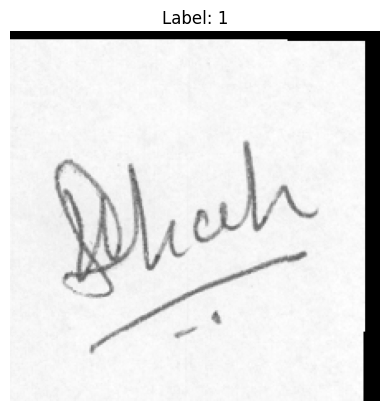

In [9]:
# Verify a single batch
import matplotlib.pyplot as plt

# Get one batch of training data
data_iter = iter(train_loader)
images, labels = next(data_iter)

# Plot the first image in the batch
plt.imshow(images[0].permute(1, 2, 0).squeeze(), cmap="gray")  # Adjust for grayscale
plt.title(f"Label: {labels[0]}")
plt.axis("off")
plt.show()

print(f"Batch size: {images.size(0)}, Image shape: {images[0].shape}")

In [29]:
import torch
import torch.nn as nn
import timm

# Load the pre-trained ViT model
model = timm.create_model('vit_base_patch16_224', pretrained=True)

# Modify the input layer to accept single-channel images
model.patch_embed.proj = nn.Conv2d(
    in_channels=1,
    out_channels=model.patch_embed.proj.out_channels,
    kernel_size=model.patch_embed.proj.kernel_size,
    stride=model.patch_embed.proj.stride,
    padding=model.patch_embed.proj.padding,
    bias=model.patch_embed.proj.bias is not None
)

# Adjust the classification head for binary classification
num_features = model.head.in_features
model.head = nn.Linear(num_features, 2)  # Two output classes

# Move model to device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Adjust dropout rates for regularization
model.drop_rate = 0.1  # Dropout after attention and MLP layers
model.attn_drop_rate = 0.1  # Dropout within attention layers
model.drop_path_rate = 0.1  # Stochastic depth

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

print("Model setup completed successfully!")
device
print("Modified input layer:")
print(model.patch_embed.proj)



Model setup completed successfully!
Modified input layer:
Conv2d(1, 768, kernel_size=(16, 16), stride=(16, 16))


In [11]:
# # Freeze all layers except the classification head
# for param in model.parameters():
#     param.requires_grad = False

# # Unfreeze the classification head
# for param in model.head.parameters():
#     param.requires_grad = True

# # Also unfreeze the input layer since we modified it
# for param in model.patch_embed.proj.parameters():
#     param.requires_grad = True

In [12]:
# # Define different parameter groups
# optimizer = torch.optim.Adam([
#     {'params': model.patch_embed.proj.parameters(), 'lr': 1e-4},
#     {'params': model.head.parameters(), 'lr': 1e-4},
#     {'params': model.parameters(), 'lr': 1e-5}  # Rest of the model
# ], lr=1e-5)

In [30]:
def train_one_epoch(model, optimizer, criterion, dataloader, device):
    model.train()  # Set model to training mode
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in dataloader:
        images = images.to(device)
        labels = labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Statistics
        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / total
    epoch_acc = 100 * correct / total

    return epoch_loss, epoch_acc

In [31]:
def validate(model, criterion, dataloader, device):
    model.eval()  # Set model to evaluation mode
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():  # Disable gradient computation
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Statistics
            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / total
    epoch_acc = 100 * correct / total

    return epoch_loss, epoch_acc

In [32]:
# Get one batch of data
data_iter = iter(train_loader)
images, labels = next(data_iter)

print(f"Image batch shape: {images.shape}")
# Expected output: [batch_size, 1, 224, 224]

Image batch shape: torch.Size([32, 1, 224, 224])


In [ ]:
import time

num_epochs = 10  # You can adjust this number
best_val_acc = 0.0

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    start_time = time.time()

    # Training phase
    train_loss, train_acc = train_one_epoch(model, optimizer, criterion, train_loader, device)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # Validation phase
    val_loss, val_acc = validate(model, criterion, val_loader, device)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    # Check if this is the best model so far
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        # Save the best model weights
        torch.save(model.state_dict(), 'best_model.pth')

    end_time = time.time()
    epoch_time = end_time - start_time

    print(f'Epoch [{epoch+1}/{num_epochs}]')
    print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
    print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')
    print(f'Epoch Time: {epoch_time:.2f} seconds\n')

print('Training complete.')

Epoch [1/10]
Train Loss: 0.6633, Train Acc: 66.05%
Val Loss: 0.1865, Val Acc: 92.91%
Epoch Time: 73.98 seconds

Epoch [2/10]
Train Loss: 0.5121, Train Acc: 75.91%
Val Loss: 0.3155, Val Acc: 84.56%
Epoch Time: 67.12 seconds

Epoch [3/10]
Train Loss: 0.1969, Train Acc: 93.39%
Val Loss: 0.4815, Val Acc: 65.57%
Epoch Time: 66.72 seconds



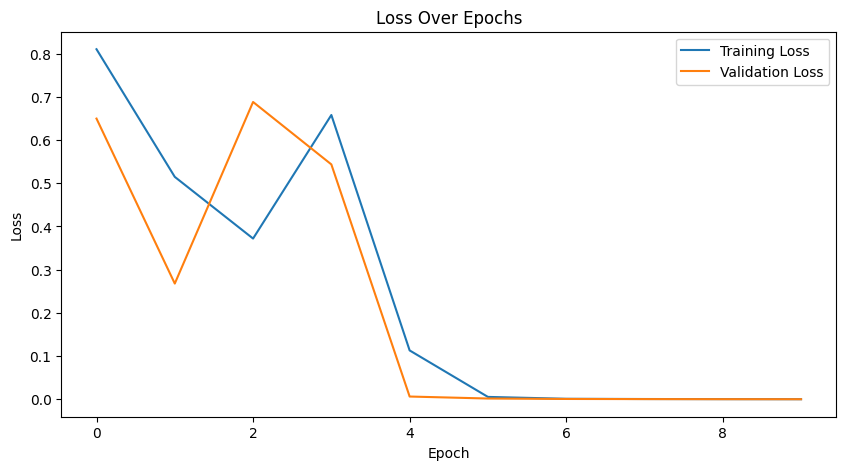

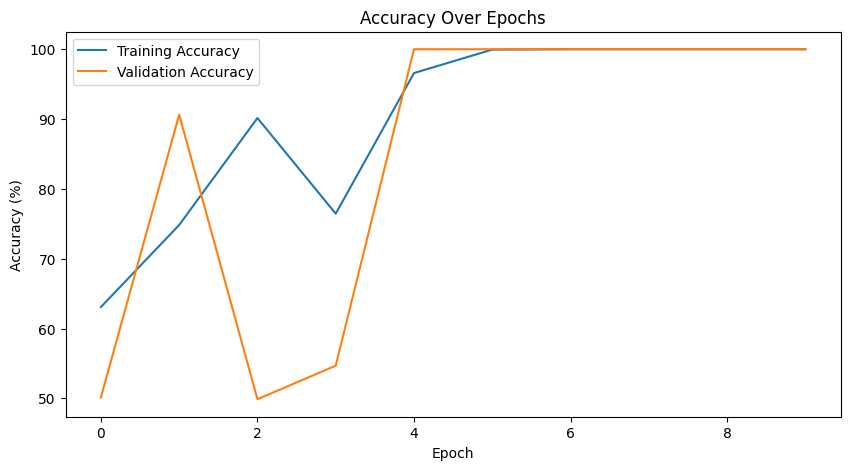

In [17]:
import matplotlib.pyplot as plt

# Plot loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()

In [18]:
# Load the best model weights
model.load_state_dict(torch.load('best_model.pth'))

# Evaluate on test set
test_loss, test_acc = validate(model, criterion, test_loader, device)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}%')

<ipython-input-18-3000f3498195>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


Test Loss: 0.0067, Test Accuracy: 100.00%


In [19]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

model.eval()
all_labels = []
all_preds = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

# Generate classification report
print(classification_report(all_labels, all_preds, target_names=['Genuine', 'Forged']))

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)
print('Confusion Matrix:')
print(cm)

              precision    recall  f1-score   support

     Genuine       1.00      1.00      1.00       199
      Forged       1.00      1.00      1.00       199

    accuracy                           1.00       398
   macro avg       1.00      1.00      1.00       398
weighted avg       1.00      1.00      1.00       398

Confusion Matrix:
[[199   0]
 [  0 199]]


In [20]:
# Assuming all_labels and all_preds are already defined
import matplotlib.pyplot as plt

misclassified_indices = [i for i, (pred, label) in enumerate(zip(all_preds, all_labels)) if pred != label]

# Get some misclassified samples
num_samples = 5  # Number of samples to display
misclassified_samples = misclassified_indices[:num_samples]

for idx in misclassified_samples:
    image, label = test_dataset[idx]
    image = image.to(device)
    output = model(image.unsqueeze(0))
    _, predicted = torch.max(output.data, 1)

    plt.imshow(image.cpu().permute(1, 2, 0).squeeze(), cmap='gray')
    plt.title(f'Actual: {label}, Predicted: {predicted.item()}')
    plt.axis('off')
    plt.show()

In [21]:
torch.save(model.state_dict(), 'final_model.pth')

In [22]:
# Load the best model weights
model.load_state_dict(torch.load('best_model.pth'))

# Set the model to evaluation mode
model.eval()

<ipython-input-22-2b02afcb27ce>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(1, 768, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identity(

In [23]:
def test_model(model, criterion, dataloader, device):
    model.eval()  # Set model to evaluation mode
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():  # Disable gradient computation
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Accumulate loss
            running_loss += loss.item() * images.size(0)

            # Calculate predictions
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Calculate loss and accuracy
    test_loss = running_loss / total
    test_acc = 100 * correct / total

    return test_loss, test_acc

In [ ]:
# Evaluate on the test set
test_loss, test_acc = test_model(model, criterion, test_loader, device)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.2f}%")

Test Loss: 0.0067
Test Accuracy: 100.00%


In [25]:
from sklearn.metrics import classification_report

# Collect all predictions and labels
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Generate classification report
target_names = ['Genuine', 'Forged']
print(classification_report(all_labels, all_preds, target_names=target_names))

              precision    recall  f1-score   support

     Genuine       1.00      1.00      1.00       199
      Forged       1.00      1.00      1.00       199

    accuracy                           1.00       398
   macro avg       1.00      1.00      1.00       398
weighted avg       1.00      1.00      1.00       398



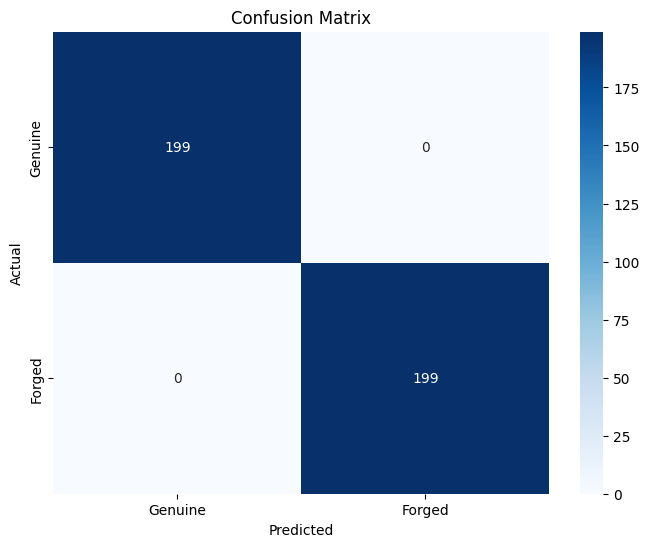

In [26]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [27]:
# Identify misclassified samples
misclassified_indices = [i for i, (label, pred) in enumerate(zip(all_labels, all_preds)) if label != pred]

# Visualize a few misclassified examples
num_samples = 5
for idx in misclassified_indices[:num_samples]:
    img, label = test_dataset[idx]
    img = img.squeeze().numpy()  # Convert to NumPy array
    plt.imshow(img, cmap='gray')
    plt.title(f"Actual: {target_names[label]}, Predicted: {target_names[all_preds[idx]]}")
    plt.axis('off')
    plt.show()